#Лабораторная работа №2 по дисциплине "Технологии обеспечения информационной безопасности"

Егоров Ю.А. Вариант 2. 

Исходя из занания был разработан парсер для анализа логов apache сервера.

Анализ структуры лог файлов для создаия парсера.

Дата и время: Feb 1 00:00:02

Имя устройства: bridge

Ядро (kernel): kernel

Тип сообщения: INBOUND TCP

Входящий интерфейс: IN=br0

Физический входной интерфейс: PHYSIN=eth0

Исходящий интерфейс: OUT=br0

Физический выходной интерфейс: PHYSOUT=eth1

Исходный IP-адрес: SRC=192.150.249.87

Целевой IP-адрес: DST=11.11.11.84

Длина сообщения: LEN=40

TOS (Type of Service): TOS=0x00

PREC (Precedence): PREC=0x00

TTL (Time To Live): TTL=110

ID: ID=12973

Протокол: PROTO=TCP

Порт источника: SPT=220

Порт назначения: DPT=6129

Окно: WINDOW=16384

RES: RES=0x00

Флаг SYN: SYN

URG pointer: URGP=0


Выполнения задания и вывод графиков 

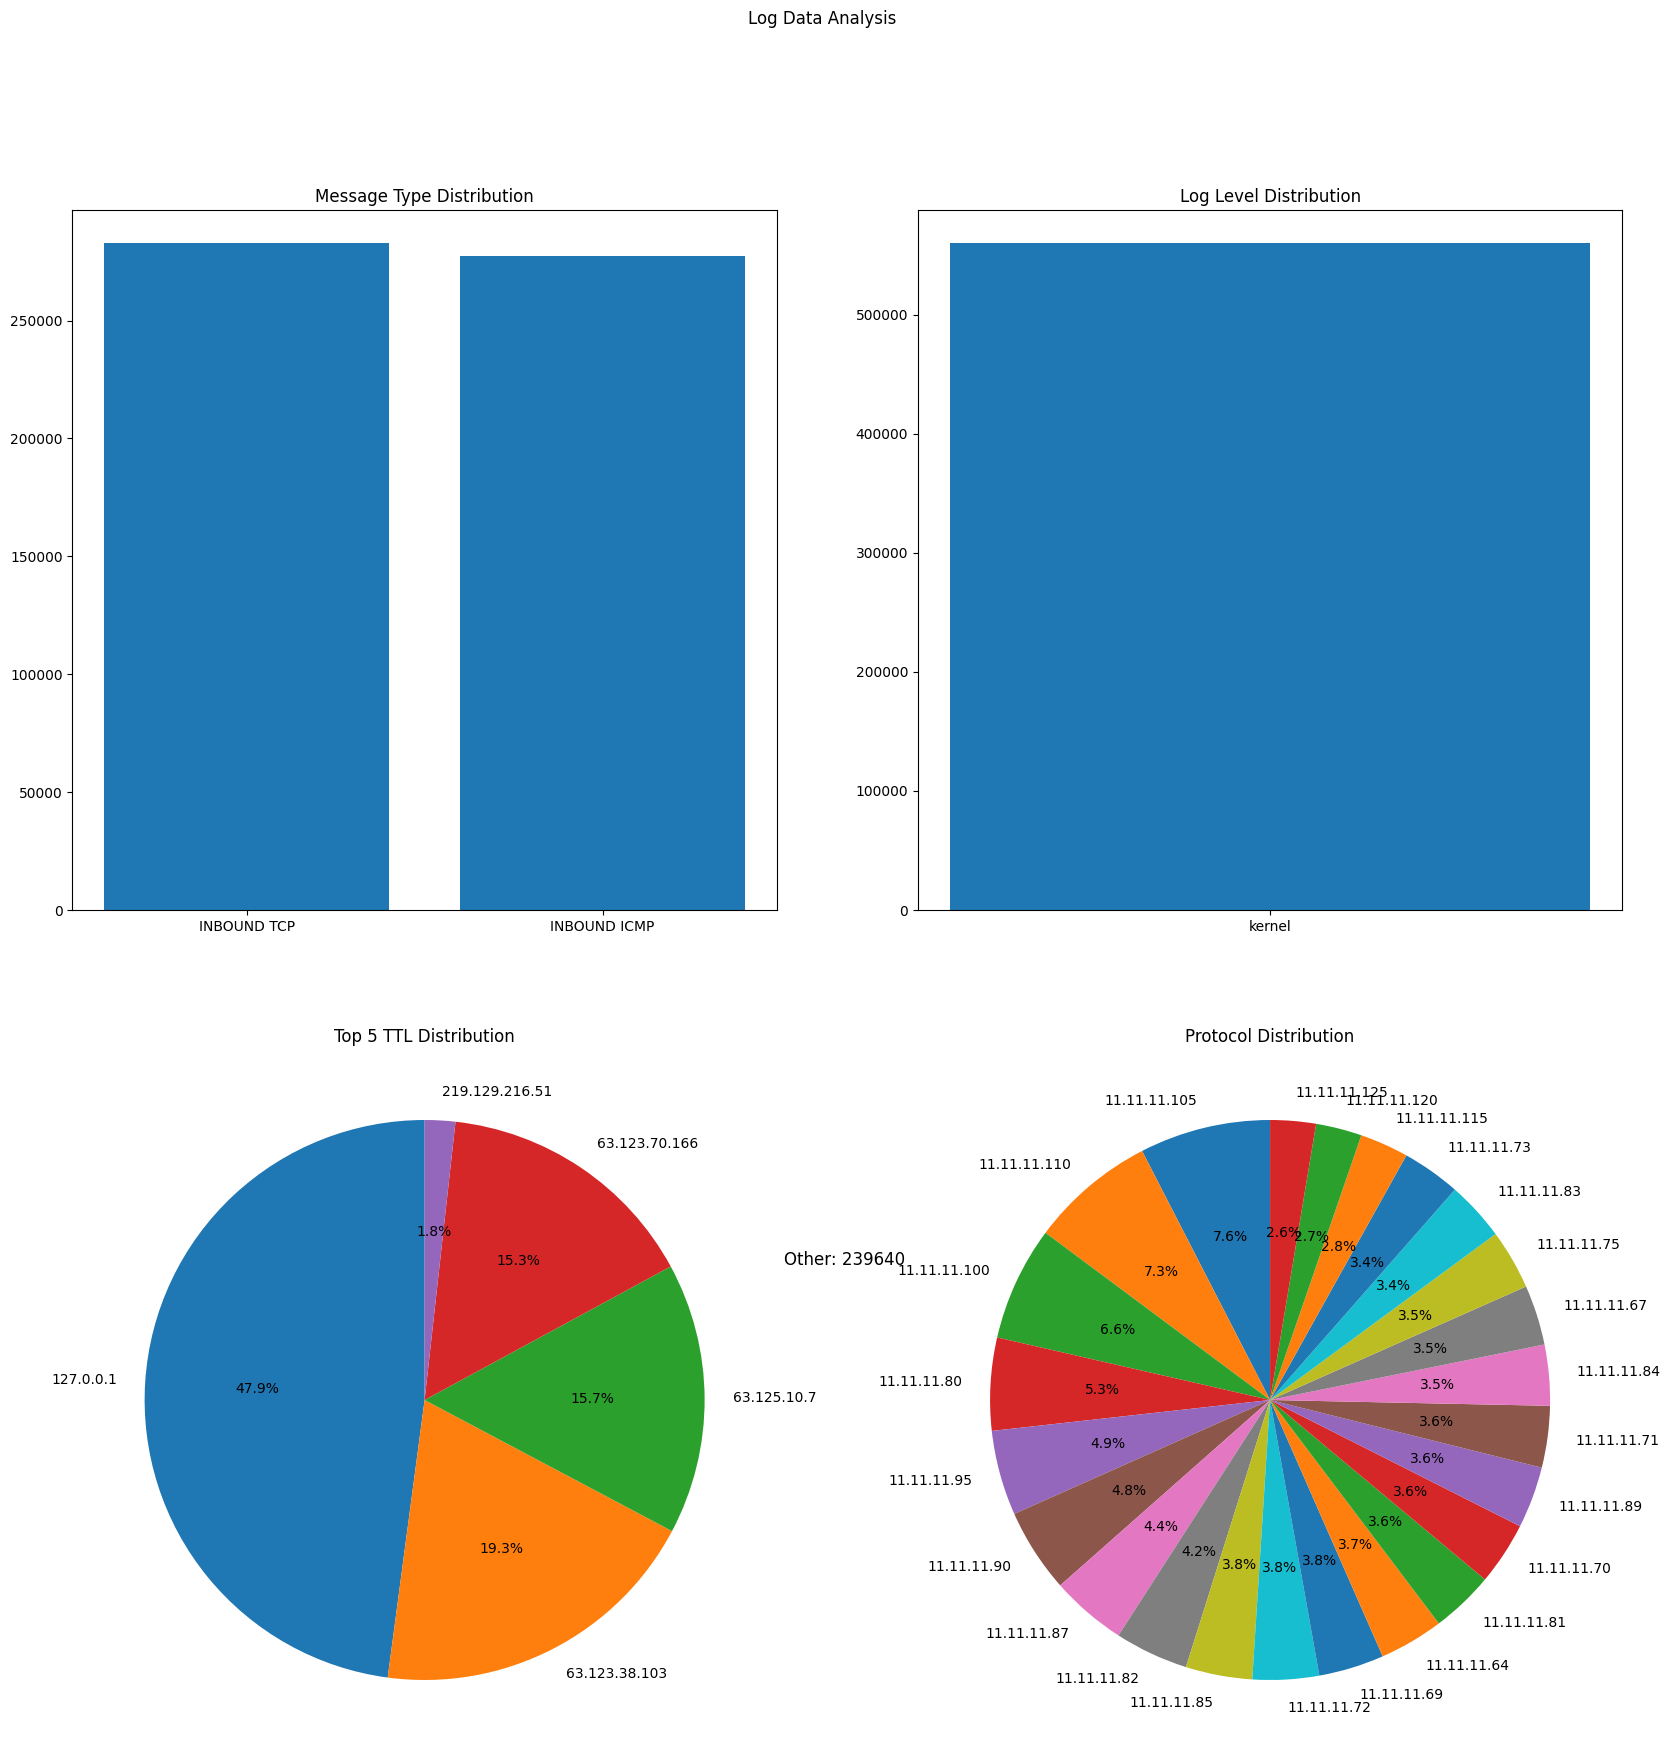

In [16]:
import sqlite3
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Замените путь к файлу на путь к вашему файлу CSV
file_path = "/Users/egorov_y/TOIB/lab_2/SotM30-anton.csv"

# Чтение логов из файла
with open(file_path, 'r') as file:
    log_data = file.read()

# Пример упрощенного парсера
regex_pattern = r'(\w{3} \d{1,2} \d{2}:\d{2}:\d{2}) (\S+) (\S+): (\S+ \S+): (\S+)=([\w\d.:]+) (\S+)=([\w\d.:]+) (\S+)=([\w\d.:]+) (\S+)=([\w\d.:]+) (\S+)=([\w\d.:]+) (\S+)=([\w\d.:]+) (\S+)=([\w\d.:]+) (\S+)=([\w\d.:]+) (\S+)=([\w\d.:]+) (\S+)=([\w\d.:]+) (\S+)=([\w\d.:]+) (\S+)=([\w\d.:]+) (\S+)=([\w\d.:]+) (\S+)=([\w\d.:]+) (\S+)=([\w\d.:]+) (\S+)=([\w\d.:]+)'

matches = re.finditer(regex_pattern, log_data)

# Подключение к SQLite базе данных
conn = sqlite3.connect('logs.db')
cursor = conn.cursor()

# Создание таблицы, если она не существует
cursor.execute('''
    CREATE TABLE IF NOT EXISTS logs (
        date_and_time TEXT,
        device_name TEXT,
        kernel TEXT,
        message_type TEXT,
        incoming_interface TEXT,
        physical_incoming_interface TEXT,
        outgoing_interface TEXT,
        physical_outgoing_interface TEXT,
        source_ip TEXT,
        destination_ip TEXT,
        length TEXT,
        tos TEXT,
        prec TEXT,
        ttl TEXT,
        log_id TEXT,
        protocol TEXT,
        source_port TEXT,
        destination_port TEXT,
        window TEXT,
        res TEXT,
        flag_syn TEXT,
        urg_pointer TEXT
    )
''')

# Вставка данных в таблицу
for match in matches:
    groups = match.groups()
    cursor.execute('''
        INSERT INTO logs VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', groups[:22])

# Сохранение изменений и закрытие соединения
conn.commit()
conn.close()

# Установите соединение с базой данных
conn = sqlite3.connect('logs.db')  # Подставьте ваше соединение с базой данных

# Прочитайте данные из базы данных в DataFrame
df = pd.read_sql_query('SELECT * FROM logs', conn)

# Закройте соединение
conn.close()

ttl_counts = df['ttl'].value_counts()
# Создайте сетку графиков
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Пример анализа уровней логирования
log_level_counts = df['message_type'].value_counts()
axs[0, 0].bar(log_level_counts.index, log_level_counts)
axs[0, 0].set_title('Message Type Distribution')

# Зависимость 2: Распределение уровней логирования
log_level_counts = df['kernel'].value_counts()
axs[0, 1].bar(log_level_counts.index, log_level_counts)
axs[0, 1].set_title('Log Level Distribution')

# Зависимость 4: Распределение протоколов
protocol_pie = df['protocol'].value_counts()
axs[1, 1].pie(protocol_pie, labels=protocol_pie.index, autopct='%1.1f%%', startangle=90)
axs[1, 1].set_title('Protocol Distribution')
# Сохранение графика в изображение с настройкой макета
plt.savefig('protocol_distribution.png', bbox_inches='tight', pad_inches=0.5)


top_ttl_counts = ttl_counts.head(5)
other_ttl_counts = ttl_counts[~ttl_counts.index.isin(top_ttl_counts.index)]
# Строим круговую диаграмму для топ-10 записей
axs[1, 0].pie(top_ttl_counts, labels=top_ttl_counts.index, autopct='%1.1f%%', startangle=90)
axs[1, 0].set_title('Top 5 TTL Distribution')
# Выводим остальные записи как "Other"
axs[1, 0].text(1.5, 0.5, f'Other: {other_ttl_counts.sum()}', horizontalalignment='center', verticalalignment='center', fontsize=12)

# Установите общий заголовок
fig.suptitle('Log Data Analysis')

# Покажите графики
plt.show()



Анализ данных и построение графиков: